In [0]:
!apt-get install openjdk-8-jdk-headless -qq
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-preview2-bin-hadoop3.2.tgz
!pip install -q findspark
!ls

s3.csv	     spark-3.0.0-preview2-bin-hadoop3.2
sample_data  spark-3.0.0-preview2-bin-hadoop3.2.tgz


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
spark = SparkSession.builder.master("local[*]").getOrCreate()

import numpy as np

In [0]:
#data = spark.read.csv('s3.csv', inferSchema=True, header=False)
data = spark.sparkContext.textFile('s3.csv')
data = data.map(lambda line: line.split(","))
data = data.map(lambda line: np.array([float(line[0]), float(line[1])]))

In [0]:
# Question 1
#KMeans Clustering with random initialization
def kMeansMapReduce(data, k, eps=1e-4, seed=None):
  np.random.seed(seed)
  centroids = np.array(data.collect())[np.random.randint(0, data.count(), k)]
  old_centroids = np.zeros_like(centroids)
  while (centroids - old_centroids).mean() > eps:
    old_centroids = centroids
    distance = data.map(lambda point: (np.argmin(np.sum((point - centroids)**2, axis=1)), (point, 1)))
    clustered = distance.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])).collect()
    centroids = np.asarray([c[1][0] / c[1][1] for c in clustered])
  labels = np.array(data.map(lambda point: (np.argmin(np.sum((point - centroids)**2, axis=1)))).collect(), dtype=np.int)
  return centroids, labels

In [0]:
centroids, labels = kMeansMapReduce(data, 15, seed=0)

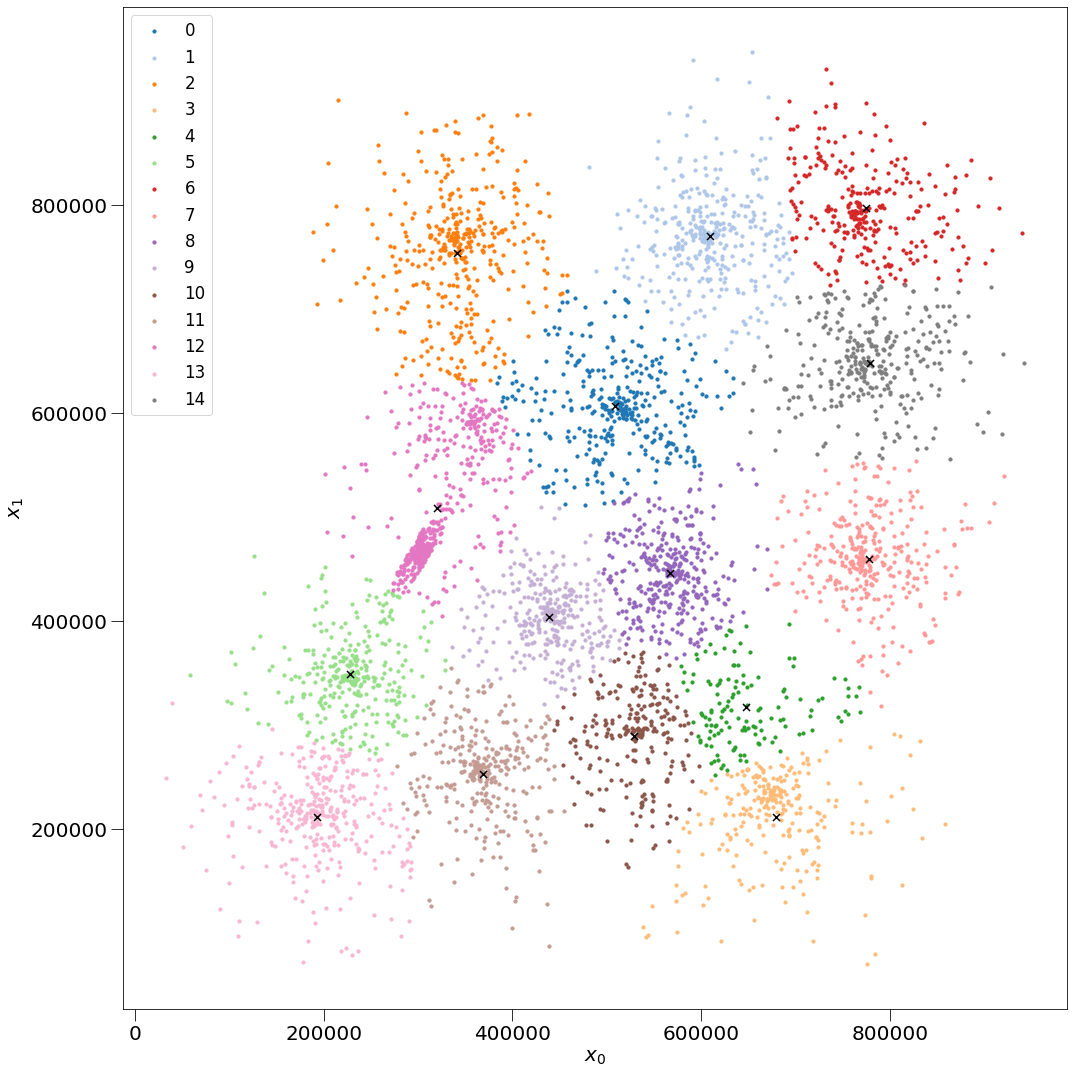

In [0]:
# Question 2

import matplotlib as mpl
import matplotlib.pyplot as plt

height = 15
width = 15

mpl.rcParams['figure.figsize'] = (width, height)
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 12
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.labelsize'] = 20

x = np.array(data.collect())
cmap = plt.cm.get_cmap('tab20')
fig, ax = plt.subplots()
for cluster in np.unique(labels):
  ax.scatter(x[:,0][labels == cluster], x[:,1][labels == cluster], 10, c=np.array([cmap(cluster)]), label=cluster)
  ax.scatter(centroids[cluster,0], centroids[cluster,1], 50, marker='x', color='black')
ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')
ax.legend()
fig.tight_layout(pad=0.5)
fig.savefig('a3_kmeans.png', dpi=200)

In [0]:
np.savetxt('s3_labels.csv', labels, delimiter=',', fmt='%i')